Cosine similarity finds the group of students who have similar shape of grade curve (i.e. stu_1 whose grades (0.6, 1.0, 0.8) is considered similar with stu_2 whose grades (0.3, 0.5, 0.4)). The prediction result is computed by mean([FinalGrade(stu_1)*norm(stu_input)/norm(stu_1), FinalGrade(stu_2)*norm(stu_input)/norm(stu_2), FinalGrade(stu_3)*norm(stu_input)/norm(stu_3), ...])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import f1_score,recall_score,precision_score,roc_curve,roc_auc_score,accuracy_score,confusion_matrix,r2_score
import warnings
from numpy.linalg import norm
import matplotlib.pyplot as plt

Read student data

In [ ]:
df = pd.read_excel('2015-2017 CSCA08 Student Data.xlsx')
df = df.fillna(0)
df

,Year,Id,UTorID,Type,Gender,Gender2,Exe0,Exe1,Exe2,Exe3,...,TT1,TT2,EX,EX.1,FinalGrade,Status,DropTime,PartialGrade,Assignment Partial,Mid Term Partial
0,2015,9.902906e+08,dcostaad,Domestic,MR,Male,1.0,1.000000,0.818182,1.000000,...,0.816667,0.800000,0.67,0.67,0.774253,Complete,0,0.868835,0.908310,0.808333
1,2015,9.982007e+08,wangjunq,International,MR,Male,0.0,1.000000,0.909091,1.000000,...,0.566667,0.466667,0.43,0.43,0.559584,Complete,0,0.641919,0.776137,0.516667
2,2015,9.983004e+08,xuzheng,Domestic,MR,Male,1.0,1.000000,0.818182,1.000000,...,0.658333,0.733333,0.56,0.56,0.657379,Complete,0,0.812951,0.914187,0.695833
3,2015,9.983261e+08,leehyu37,International,MR,Male,1.0,0.666667,0.818182,0.916667,...,0.583333,0.866667,0.84,0.84,0.837111,Complete,0,0.801598,0.863400,0.725000
4,2015,9.984079e+08,khanmu31,Domestic,MR,Male,0.0,1.000000,0.545455,1.000000,...,0.541667,0.400000,0.37,0.37,0.394412,Complete,0,0.552943,0.775221,0.470833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,2017,1.004574e+09,zhanjenk,Domestic,0,0,1.0,1.000000,0.714000,0.737000,...,0.000000,0.000000,0.00,0.00,0.000000,EX5,before,0.000000,0.000000,0.000000
2364,2017,1.003323e+09,zhaodav3,Domestic,MR,Male,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,EX1,before,0.000000,0.000000,0.000000
2365,2017,1.003779e+09,zhaoyu79,International,MS,Female,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,EX1,before,0.000000,0.000000,0.000000
2366,2017,1.003557e+09,zhouwe42,International,MISS,Female,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.00,0.000000,EX1,before,0.000000,0.000000,0.000000


Create dataframe for students completed the course or dropped

In [ ]:
df_no_drop = df[df['EX'] != 0]
df_dropped = df[df['EX'] == 0]

Create event sequences (as input of the model), which can be any sequenced subset of the event sequence.

In [ ]:
event_sequence = ['Exe0', 'Exe1', 'TT1', 'Exe2', 'Exe3', 'A1', 'Exe4', 'Exe5', 'Exe6', 'TT2', 'Exe7', 'A2', 'Exe8', 'Exe9', 'Exe10', 'A3', 'EX', 'FinalGrade']
no_final_grade = ['Exe0', 'Exe1', 'TT1', 'Exe2', 'Exe3', 'A1', 'Exe4', 'Exe5', 'Exe6', 'TT2', 'Exe7', 'A2', 'Exe8', 'Exe9', 'Exe10', 'A3', 'EX']
big_event = ['TT1', 'A1', 'TT2', 'A2', 'A3']


In [ ]:
weight = [0.01, 0.01, 0.125, 0.01, 0.01, 0.06666667, 0.01, 0.01, 0.01, 0.125, 0.01, 0.06666667, 0.01, 0.01, 0.01, 0.06666667, 0.4]


In [ ]:
def get_GPA(grade):
  result = [0 for i in range(13)]
  if grade > 0.89:
    result[0] = 1
  elif grade > 0.84:
    result[1] = 1
  elif grade > 0.79:
    result[2] = 1
  elif grade > 0.76:
    result[3] = 1
  elif grade > 0.72:
    result[4] = 1
  elif grade > 0.69:
    result[5] = 1
  elif grade > 0.66:
    result[6] = 1
  elif grade > 0.62:
    result[7] = 1
  elif grade > 0.59:
    result[8] = 1
  elif grade > 0.56:
    result[9] = 1
  elif grade > 0.52:
    result[10] = 1
  elif grade > 0.49:
    result[11] = 1
  elif grade >= 0:
    result[12] = 1
  return result


In [ ]:
def model(x_train, input, acc, events):
  """
  Return the final grades of the students who have
  the cosine similarity > acc, and the students
  """
  df_temp = x_train[x_train['Id'] != input['Id']]
  input = input[events].astype('float64').to_numpy()
  arr = df_temp[events].to_numpy()
  den = np.sqrt(np.einsum('ij,ij->i', arr, arr)*np.einsum('j,j',input, input))
  with np.errstate(divide='ignore', invalid='ignore'):
    cos = arr.dot(input) / den
    cos[np.isnan(cos)] = 0.0
  df_simi_stu = df_temp.iloc[np.where(cos > acc)[0], :]
  norm_l = norm(df_simi_stu[events].to_numpy(), axis=1)
  ratio_l = norm(input) / norm_l
  grades = (df_simi_stu['FinalGrade'].to_list() * ratio_l).tolist()
  return [grades, df_simi_stu]

def model_weighted(x_train, input, acc, events):
  """
  Return the final grades of the students who have
  the weighted cosine similarity > acc, and the students
  """
  df_temp = x_train[x_train['Id'] != input['Id']]
  input = input[no_final_grade]*weight
  input = input[events].astype('float64').to_numpy()
  df_weighted = df_temp[no_final_grade]*weight
  arr = df_weighted[events].to_numpy()
  den = np.sqrt(np.einsum('ij,ij->i', arr, arr)*np.einsum('j,j',input, input))
  with np.errstate(divide='ignore', invalid='ignore'):
    cos = arr.dot(input) / den
    cos[np.isnan(cos)] = 0.0
  df_simi_stu = df_temp.iloc[np.where(cos > acc)[0], :]
  df_weighted_stu = df_weighted.iloc[np.where(cos > acc)[0], :]
  norm_l = norm(df_weighted_stu[events].to_numpy(), axis=1)
  ratio_l = norm(input) / norm_l
  grades = (df_simi_stu['FinalGrade'].to_list() * ratio_l).tolist()
  return [grades, df_simi_stu]

def model_top_n(x_train, input, n, events):
  """
  Return the final grades of the students who have
  the weighted cosine similarity > acc, and the students
  """
  df_temp = x_train[x_train['Id'] != input['Id']]
  input = input[no_final_grade]*weight
  input = input[events].astype('float64').to_numpy()
  df_weighted = df_temp[no_final_grade]*weight
  arr = df_weighted[events].to_numpy()
  den = np.sqrt(np.einsum('ij,ij->i', arr, arr)*np.einsum('j,j',input, input))
  with np.errstate(divide='ignore', invalid='ignore'):
    cos = arr.dot(input) / den
    cos[np.isnan(cos)] = 0.0
  df_simi_stu = df_temp.iloc[np.argpartition(cos, -n)[-n:], :]
  df_weighted_stu = df_weighted.iloc[np.argpartition(cos, -n)[-n:], :]
  norm_l = norm(df_weighted_stu[events].to_numpy(), axis=1)
  with np.errstate(divide='ignore', invalid='ignore'):
    ratio_l = norm(input) / norm_l
    ratio_l[np.isnan(ratio_l)] = 0.0
  grades = (df_simi_stu['FinalGrade'].to_list() * ratio_l).tolist()
  return [grades, df_simi_stu]


def loss_f(pred, target):
  result = 0
  for grades, y in zip(pred, target):
    loss = ((np.array(grades)-y)**2).mean() if len(grades) > 0 else y**2
    result += loss
  return result / target.size

def loss_g1(pred, target):
  """
  Return the mean of the loss of a single data point, which is mean of 
  the absolute difference. If pred is empty, the the loss is target.
  """
  result = 0
  for grades, y in zip(pred, target):
    loss = (np.absolute((np.array(grades)-y))).mean() if len(grades) > 0 else y
    result += loss
  return result / target.size

def loss_g2(pred, target):
  """
  Return the mean of the loss of a single data point, which is mean of 
  the absolute difference. If pred is empty, ignore the data point
  """
  result = 0
  count = 0
  for grades, y in zip(pred, target):
    if len(grades) > 0:
      loss = (np.absolute((np.array(grades)-y))).mean()
      result += loss
      count += 1
  return [result / count if count > 0 else np.nan, count/target.size]

In [ ]:
def eval_model(events, radius):
  x = df_no_drop
  y = x['FinalGrade']
  events = events
  
  train_loss_l_g2_temp = []
  train_rate_l_g2_temp = []
  test_loss_l_g2_temp = []
  test_rate_l_g2_temp = []
  for i in range(2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random.randint(1, 1000))
    y_train_pred = x_train.apply(lambda x: model(x_train, x, radius, events)[0], axis=1)
    y_test_pred = x_test.apply(lambda x: model(x_train, x, radius, events)[0], axis=1)
    train_loss_temp_g2, train_rate_temp_g2 = loss_g2(y_train_pred, y_train)
    test_loss_temp_g2, test_rate_temp_g2 = loss_g2(y_test_pred, y_test)
    y_train = y_train.apply(lambda x: get_GPA(x))
    y_test = y_test.apply(lambda x: get_GPA(x))
    y_train_pred = y_train_pred.apply(lambda x: get_GPA(sum(x)/len(x) if len(x) > 0 else 0))    
    y_test_pred = y_test_pred.apply(lambda x: get_GPA(sum(x)/len(x) if len(x) > 0 else 0))

    train_loss_l_g2_temp.append(train_loss_temp_g2)
    train_rate_l_g2_temp.append(train_rate_temp_g2)
    test_loss_l_g2_temp.append(test_loss_temp_g2)
    test_rate_l_g2_temp.append(test_rate_temp_g2)
  train_loss_g2 = sum(train_loss_l_g2_temp)/len(train_loss_l_g2_temp)
  train_rate_g2 = sum(train_rate_l_g2_temp)/len(train_rate_l_g2_temp)
  test_loss_g2 = sum(test_loss_l_g2_temp)/len(test_loss_l_g2_temp)
  test_rate_g2 = sum(test_rate_l_g2_temp)/len(test_rate_l_g2_temp)

  print('Time_stamp %.0f'%len(events), 'radius %.4f'%radius, 'train_loss_g2 %.5f'%train_loss_g2, 'train_rate_g2 %.5f'%train_rate_g2, 'test_loss_g2 %.5f'%test_loss_g2, 'test_rate_g2 %.5f'%test_rate_g2)
  return [train_loss_g2, train_rate_g2, test_loss_g2, test_rate_g2]

In [ ]:
def eval_weighted_model(events, radius):
  x = df_no_drop
  y = x['FinalGrade']
  events = events
  
  train_loss_l_g2_temp = []
  train_rate_l_g2_temp = []
  test_loss_l_g2_temp = []
  test_rate_l_g2_temp = []
  for i in range(2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random.randint(1, 1000))
    y_train_pred = x_train.apply(lambda x: model_weighted(x_train, x, radius, events)[0], axis=1)
    y_test_pred = x_test.apply(lambda x: model_weighted(x_train, x, radius, events)[0], axis=1)
    train_loss_temp_g2, train_rate_temp_g2 = loss_g2(y_train_pred, y_train)
    test_loss_temp_g2, test_rate_temp_g2 = loss_g2(y_test_pred, y_test)
    y_train = y_train.apply(lambda x: get_GPA(x))
    y_test = y_test.apply(lambda x: get_GPA(x))
    y_train_pred = y_train_pred.apply(lambda x: get_GPA(sum(x)/len(x) if len(x) > 0 else 0))    
    y_test_pred = y_test_pred.apply(lambda x: get_GPA(sum(x)/len(x) if len(x) > 0 else 0))

    train_loss_l_g2_temp.append(train_loss_temp_g2)
    train_rate_l_g2_temp.append(train_rate_temp_g2)
    test_loss_l_g2_temp.append(test_loss_temp_g2)
    test_rate_l_g2_temp.append(test_rate_temp_g2)
  train_loss_g2 = sum(train_loss_l_g2_temp)/len(train_loss_l_g2_temp)
  train_rate_g2 = sum(train_rate_l_g2_temp)/len(train_rate_l_g2_temp)
  test_loss_g2 = sum(test_loss_l_g2_temp)/len(test_loss_l_g2_temp)
  test_rate_g2 = sum(test_rate_l_g2_temp)/len(test_rate_l_g2_temp)

  print('Time_stamp %.0f'%len(events), 'radius %.4f'%radius, 'train_loss_g2 %.5f'%train_loss_g2, 'train_rate_g2 %.5f'%train_rate_g2, 'test_loss_g2 %.5f'%test_loss_g2, 'test_rate_g2 %.5f'%test_rate_g2)
  return [train_loss_g2, train_rate_g2, test_loss_g2, test_rate_g2]

In [ ]:
def eval_top_n_model(events, n):
  x = df_no_drop
  y = x['FinalGrade']
  events = events
  
  train_loss_l_g2_temp = []
  train_rate_l_g2_temp = []
  test_loss_l_g2_temp = []
  test_rate_l_g2_temp = []
  for i in range(2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random.randint(1, 1000))
    y_train_pred = x_train.apply(lambda x: model_top_n(x_train, x, n, events)[0], axis=1)
    y_test_pred = x_test.apply(lambda x: model_top_n(x_train, x, n, events)[0], axis=1)
    train_loss_temp_g2, train_rate_temp_g2 = loss_g2(y_train_pred, y_train)
    test_loss_temp_g2, test_rate_temp_g2 = loss_g2(y_test_pred, y_test)
    y_train = y_train.apply(lambda x: get_GPA(x))
    y_test = y_test.apply(lambda x: get_GPA(x))
    y_train_pred = y_train_pred.apply(lambda x: get_GPA(sum(x)/len(x) if len(x) > 0 else 0))    
    y_test_pred = y_test_pred.apply(lambda x: get_GPA(sum(x)/len(x) if len(x) > 0 else 0))

    train_loss_l_g2_temp.append(train_loss_temp_g2)
    train_rate_l_g2_temp.append(train_rate_temp_g2)
    test_loss_l_g2_temp.append(test_loss_temp_g2)
    test_rate_l_g2_temp.append(test_rate_temp_g2)
  train_loss_g2 = sum(train_loss_l_g2_temp)/len(train_loss_l_g2_temp)
  train_rate_g2 = sum(train_rate_l_g2_temp)/len(train_rate_l_g2_temp)
  test_loss_g2 = sum(test_loss_l_g2_temp)/len(test_loss_l_g2_temp)
  test_rate_g2 = sum(test_rate_l_g2_temp)/len(test_rate_l_g2_temp)

  print('Time_stamp %.0f'%len(events), 'top_n %.4f'%n, 'train_loss_g2 %.5f'%train_loss_g2, 'train_rate_g2 %.5f'%train_rate_g2, 'test_loss_g2 %.5f'%test_loss_g2, 'test_rate_g2 %.5f'%test_rate_g2)
  return [train_loss_g2, train_rate_g2, test_loss_g2, test_rate_g2]

In [ ]:
def eval_model(events, radius):
  x = df_no_drop
  y = x['FinalGrade']
  events = events
  
  train_loss_l_g2_temp = []
  train_rate_l_g2_temp = []
  test_loss_l_g2_temp = []
  test_rate_l_g2_temp = []
  for i in range(2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random.randint(1, 1000))
    y_train_pred = x_train.apply(lambda x: model(x_train, x, radius, events)[0], axis=1)
    y_test_pred = x_test.apply(lambda x: model(x_train, x, radius, events)[0], axis=1)
    train_loss_temp_g2, train_rate_temp_g2 = loss_g2(y_train_pred, y_train)
    test_loss_temp_g2, test_rate_temp_g2 = loss_g2(y_test_pred, y_test)
    y_train = y_train.apply(lambda x: get_GPA(x))
    y_test = y_test.apply(lambda x: get_GPA(x))
    y_train_pred = y_train_pred.apply(lambda x: get_GPA(sum(x)/len(x) if len(x) > 0 else 0))    
    y_test_pred = y_test_pred.apply(lambda x: get_GPA(sum(x)/len(x) if len(x) > 0 else 0))

    train_loss_l_g2_temp.append(train_loss_temp_g2)
    train_rate_l_g2_temp.append(train_rate_temp_g2)
    test_loss_l_g2_temp.append(test_loss_temp_g2)
    test_rate_l_g2_temp.append(test_rate_temp_g2)
  train_loss_g2 = sum(train_loss_l_g2_temp)/len(train_loss_l_g2_temp)
  train_rate_g2 = sum(train_rate_l_g2_temp)/len(train_rate_l_g2_temp)
  test_loss_g2 = sum(test_loss_l_g2_temp)/len(test_loss_l_g2_temp)
  test_rate_g2 = sum(test_rate_l_g2_temp)/len(test_rate_l_g2_temp)

  print('Time stamp %.0f'%len(events), 'radius %.4f'%radius, 'train_loss_g2 %.5f'%train_loss_g2, 'train_rate_g2 %.5f'%train_rate_g2, 'test_loss_g2 %.5f'%test_loss_g2, 'test_rate_g2 %.5f'%test_rate_g2)
  return [train_loss_g2, train_rate_g2, test_loss_g2, test_rate_g2]

Evaluate Cosine Similarity Model

Time stamp 1 radius 0.9800 train_loss_g2 0.18529 train_rate_g2 0.91563 test_loss_g2 0.18137 test_rate_g2 0.89394
Time stamp 2 radius 0.9800 train_loss_g2 0.18914 train_rate_g2 0.99242 test_loss_g2 0.18771 test_rate_g2 0.99174
Time stamp 3 radius 0.9800 train_loss_g2 0.14518 train_rate_g2 0.99966 test_loss_g2 0.14859 test_rate_g2 0.99862
Time stamp 4 radius 0.9800 train_loss_g2 0.14257 train_rate_g2 0.99793 test_loss_g2 0.14239 test_rate_g2 0.99725
Time stamp 5 radius 0.9800 train_loss_g2 0.13498 train_rate_g2 0.98760 test_loss_g2 0.13467 test_rate_g2 0.98485
Time stamp 6 radius 0.9800 train_loss_g2 0.12857 train_rate_g2 0.97176 test_loss_g2 0.12763 test_rate_g2 0.97796
Time stamp 7 radius 0.9800 train_loss_g2 0.12677 train_rate_g2 0.95661 test_loss_g2 0.12943 test_rate_g2 0.96281
Time stamp 8 radius 0.9800 train_loss_g2 0.11952 train_rate_g2 0.93285 test_loss_g2 0.12077 test_rate_g2 0.94077
Time stamp 9 radius 0.9800 train_loss_g2 0.11658 train_rate_g2 0.90737 test_loss_g2 0.11780 test

<AxesSubplot:>

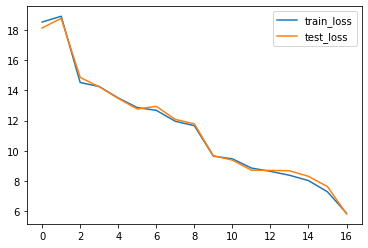

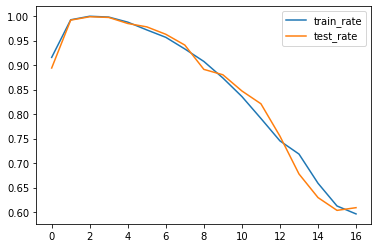

In [ ]:
eval_result = []
for i in range(1,18):
  events = [event_sequence[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_model(events, 0.98)
  eval_result.append([train_loss*100, train_rate, test_loss*100, test_rate])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'train_rate', 'test_loss', 'test_rate'])
df_eval_result[['train_loss', 'test_loss']].plot()
df_eval_result[['train_rate', 'test_rate']].plot()


Time stamp 1 radius 0.9800 train_loss_g2 0.21671 train_rate_g2 0.99518 test_loss_g2 0.21397 test_rate_g2 0.99725
Time stamp 2 radius 0.9800 train_loss_g2 0.13228 train_rate_g2 0.99828 test_loss_g2 0.13478 test_rate_g2 0.99862
Time stamp 3 radius 0.9800 train_loss_g2 0.09903 train_rate_g2 0.99828 test_loss_g2 0.09673 test_rate_g2 0.99862
Time stamp 4 radius 0.9800 train_loss_g2 0.08917 train_rate_g2 0.99483 test_loss_g2 0.08712 test_rate_g2 0.99174
Time stamp 5 radius 0.9800 train_loss_g2 0.07140 train_rate_g2 0.98588 test_loss_g2 0.07300 test_rate_g2 0.99174


<AxesSubplot:>

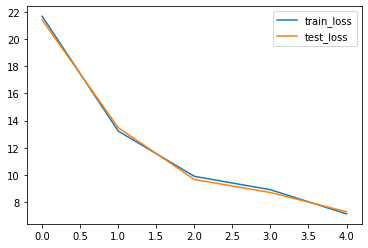

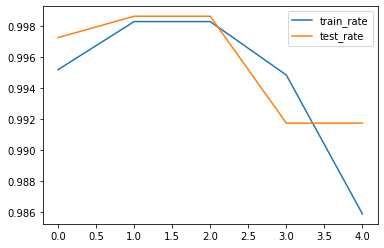

In [ ]:
eval_result = []
for i in range(1,6):
  events = [big_event[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_model(events, 0.98)
  eval_result.append([train_loss*100, train_rate, test_loss*100, test_rate])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'train_rate', 'test_loss', 'test_rate'])
df_eval_result[['train_loss', 'test_loss']].plot()
df_eval_result[['train_rate', 'test_rate']].plot()

Evaluate weighted cosine similarity model

Time_stamp 1 radius 0.9800 train_loss_g2 0.18371 train_rate_g2 0.91357 test_loss_g2 0.18381 test_rate_g2 0.90220
Time_stamp 2 radius 0.9800 train_loss_g2 0.18738 train_rate_g2 0.99380 test_loss_g2 0.18911 test_rate_g2 0.98623
Time_stamp 3 radius 0.9800 train_loss_g2 0.16416 train_rate_g2 0.99828 test_loss_g2 0.16323 test_rate_g2 0.99862
Time_stamp 4 radius 0.9800 train_loss_g2 0.15819 train_rate_g2 0.99552 test_loss_g2 0.15950 test_rate_g2 0.99449
Time_stamp 5 radius 0.9800 train_loss_g2 0.15343 train_rate_g2 0.99242 test_loss_g2 0.15244 test_rate_g2 0.98760
Time_stamp 6 radius 0.9800 train_loss_g2 0.12650 train_rate_g2 0.99070 test_loss_g2 0.12943 test_rate_g2 0.99036
Time_stamp 7 radius 0.9800 train_loss_g2 0.12678 train_rate_g2 0.98623 test_loss_g2 0.12783 test_rate_g2 0.99174
Time_stamp 8 radius 0.9800 train_loss_g2 0.12495 train_rate_g2 0.98726 test_loss_g2 0.12616 test_rate_g2 0.98898
Time_stamp 9 radius 0.9800 train_loss_g2 0.12428 train_rate_g2 0.98726 test_loss_g2 0.12278 test

<AxesSubplot:>

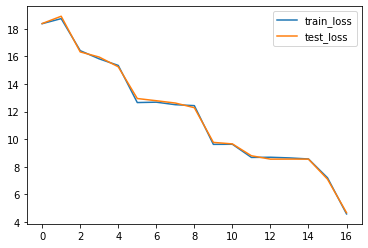

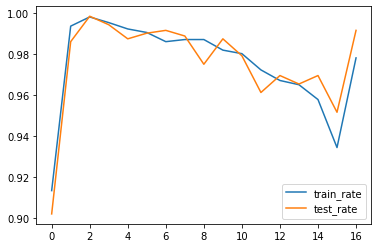

In [ ]:
eval_result = []
for i in range(1,18):
  events = [event_sequence[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_weighted_model(events, 0.98)
  eval_result.append([train_loss*100, train_rate, test_loss*100, test_rate])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'train_rate', 'test_loss', 'test_rate'])
df_eval_result[['train_loss', 'test_loss']].plot()
df_eval_result[['train_rate', 'test_rate']].plot()


Time_stamp 1 radius 0.9800 train_loss_g2 0.21648 train_rate_g2 0.99656 test_loss_g2 0.21119 test_rate_g2 0.99174
Time_stamp 2 radius 0.9800 train_loss_g2 0.13760 train_rate_g2 0.99897 test_loss_g2 0.13989 test_rate_g2 0.99587
Time_stamp 3 radius 0.9800 train_loss_g2 0.10142 train_rate_g2 0.99793 test_loss_g2 0.10172 test_rate_g2 1.00000
Time_stamp 4 radius 0.9800 train_loss_g2 0.09085 train_rate_g2 0.99621 test_loss_g2 0.08864 test_rate_g2 0.99311
Time_stamp 5 radius 0.9800 train_loss_g2 0.07601 train_rate_g2 0.98898 test_loss_g2 0.07479 test_rate_g2 0.99036


<AxesSubplot:>

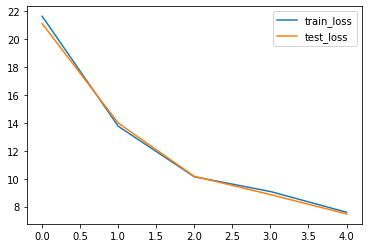

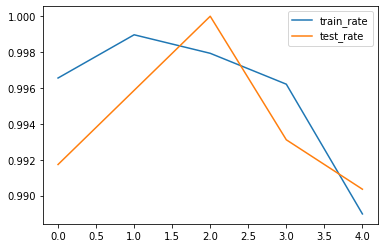

In [ ]:
train_loss_l = []
train_rate_l = []
test_loss_l = []
test_rate_l = []
eval_result = []
for i in range(1,6):
  events = [big_event[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_weighted_model(events, 0.98)
  train_loss_l.append(train_loss)
  train_rate_l.append(train_rate)
  test_loss_l.append(test_loss)
  test_rate_l.append(test_rate)
  eval_result.append([train_loss*100, train_rate, test_loss*100, test_rate])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'train_rate', 'test_loss', 'test_rate'])
df_eval_result[['train_loss', 'test_loss']].plot()
df_eval_result[['train_rate', 'test_rate']].plot()

Time_stamp 1 radius 0.9900 train_loss_g2 0.18335 train_rate_g2 0.91150 test_loss_g2 0.18439 test_rate_g2 0.91047
Time_stamp 2 radius 0.9900 train_loss_g2 0.18699 train_rate_g2 0.99311 test_loss_g2 0.18588 test_rate_g2 0.98898
Time_stamp 3 radius 0.9900 train_loss_g2 0.15654 train_rate_g2 0.99587 test_loss_g2 0.15769 test_rate_g2 1.00000
Time_stamp 4 radius 0.9900 train_loss_g2 0.15081 train_rate_g2 0.99174 test_loss_g2 0.14794 test_rate_g2 0.98760
Time_stamp 5 radius 0.9900 train_loss_g2 0.14352 train_rate_g2 0.98691 test_loss_g2 0.14436 test_rate_g2 0.98485
Time_stamp 6 radius 0.9900 train_loss_g2 0.12472 train_rate_g2 0.98588 test_loss_g2 0.12442 test_rate_g2 0.98760
Time_stamp 7 radius 0.9900 train_loss_g2 0.12276 train_rate_g2 0.97831 test_loss_g2 0.12389 test_rate_g2 0.97796
Time_stamp 8 radius 0.9900 train_loss_g2 0.12038 train_rate_g2 0.97452 test_loss_g2 0.12196 test_rate_g2 0.97521
Time_stamp 9 radius 0.9900 train_loss_g2 0.11878 train_rate_g2 0.96315 test_loss_g2 0.11891 test

<AxesSubplot:>

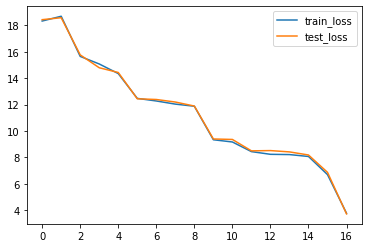

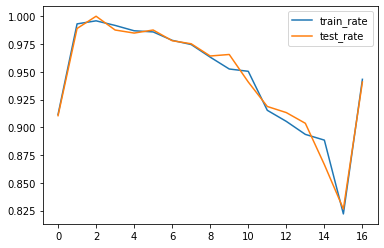

In [ ]:
train_loss_l = []
train_rate_l = []
test_loss_l = []
test_rate_l = []
eval_result = []
for i in range(1,18):
  events = [event_sequence[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_weighted_model(events, 0.99)
  train_loss_l.append(train_loss)
  train_rate_l.append(train_rate)
  test_loss_l.append(test_loss)
  test_rate_l.append(test_rate)
  eval_result.append([train_loss*100, train_rate, test_loss*100, test_rate])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'train_rate', 'test_loss', 'test_rate'])
df_eval_result[['train_loss', 'test_loss']].plot()
df_eval_result[['train_rate', 'test_rate']].plot()

Time_stamp 1 radius 0.9980 train_loss_g2 0.21252 train_rate_g2 0.99587 test_loss_g2 0.21379 test_rate_g2 0.99449
Time_stamp 2 radius 0.9980 train_loss_g2 0.13340 train_rate_g2 0.99828 test_loss_g2 0.13273 test_rate_g2 0.99725
Time_stamp 3 radius 0.9980 train_loss_g2 0.09742 train_rate_g2 0.98623 test_loss_g2 0.09803 test_rate_g2 0.98347
Time_stamp 4 radius 0.9980 train_loss_g2 0.08782 train_rate_g2 0.90117 test_loss_g2 0.08771 test_rate_g2 0.91460
Time_stamp 5 radius 0.9980 train_loss_g2 0.06948 train_rate_g2 0.75551 test_loss_g2 0.06964 test_rate_g2 0.73967


<AxesSubplot:>

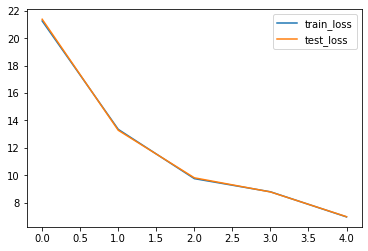

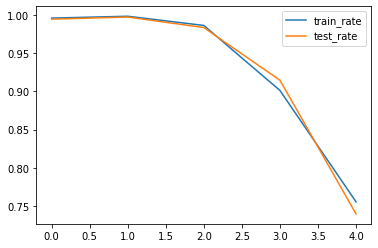

In [ ]:
eval_result = []
for i in range(1,6):
  events = [big_event[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_weighted_model(events, 0.998)
  eval_result.append([train_loss*100, train_rate, test_loss*100, test_rate])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'train_rate', 'test_loss', 'test_rate'])
df_eval_result[['train_loss', 'test_loss']].plot()
df_eval_result[['train_rate', 'test_rate']].plot()

Evaluate model_top_n

n=20

Time_stamp 1 top_n 20.0000 train_loss_g2 0.21972 train_rate_g2 1.00000 test_loss_g2 0.21721 test_rate_g2 1.00000
Time_stamp 2 top_n 20.0000 train_loss_g2 0.19401 train_rate_g2 1.00000 test_loss_g2 0.19610 test_rate_g2 1.00000
Time_stamp 3 top_n 20.0000 train_loss_g2 0.13662 train_rate_g2 1.00000 test_loss_g2 0.13952 test_rate_g2 1.00000
Time_stamp 4 top_n 20.0000 train_loss_g2 0.13142 train_rate_g2 1.00000 test_loss_g2 0.13098 test_rate_g2 1.00000
Time_stamp 5 top_n 20.0000 train_loss_g2 0.12396 train_rate_g2 1.00000 test_loss_g2 0.12370 test_rate_g2 1.00000
Time_stamp 6 top_n 20.0000 train_loss_g2 0.11546 train_rate_g2 1.00000 test_loss_g2 0.11723 test_rate_g2 1.00000
Time_stamp 7 top_n 20.0000 train_loss_g2 0.11454 train_rate_g2 1.00000 test_loss_g2 0.11559 test_rate_g2 1.00000
Time_stamp 8 top_n 20.0000 train_loss_g2 0.11097 train_rate_g2 1.00000 test_loss_g2 0.11001 test_rate_g2 1.00000
Time_stamp 9 top_n 20.0000 train_loss_g2 0.10910 train_rate_g2 1.00000 test_loss_g2 0.10834 test

<AxesSubplot:>

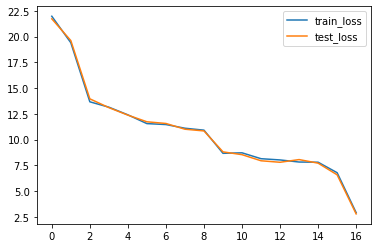

In [ ]:
eval_result = []
for i in range(1,18):
  events = [event_sequence[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_top_n_model(events, 20)
  eval_result.append([train_loss*100, test_loss*100])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'test_loss'])
df_eval_result[['train_loss', 'test_loss']].plot()

Time_stamp 1 top_n 20.0000 train_loss_g2 0.20170 train_rate_g2 1.00000 test_loss_g2 0.19860 test_rate_g2 1.00000
Time_stamp 2 top_n 20.0000 train_loss_g2 0.13196 train_rate_g2 1.00000 test_loss_g2 0.13220 test_rate_g2 1.00000
Time_stamp 3 top_n 20.0000 train_loss_g2 0.09826 train_rate_g2 1.00000 test_loss_g2 0.09872 test_rate_g2 1.00000
Time_stamp 4 top_n 20.0000 train_loss_g2 0.08712 train_rate_g2 1.00000 test_loss_g2 0.08642 test_rate_g2 1.00000
Time_stamp 5 top_n 20.0000 train_loss_g2 0.07123 train_rate_g2 1.00000 test_loss_g2 0.07233 test_rate_g2 1.00000


<AxesSubplot:>

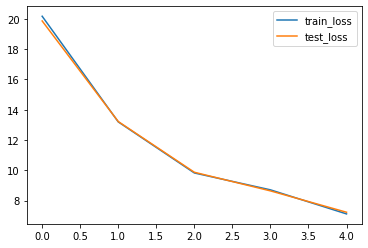

In [ ]:
eval_result = []
for i in range(1,6):
  events = [big_event[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_top_n_model(events, 20)
  eval_result.append([train_loss*100, test_loss*100])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'test_loss'])
df_eval_result[['train_loss', 'test_loss']].plot()


n=1000

Time_stamp 1 top_n 1000.0000 train_loss_g2 0.21845 train_rate_g2 1.00000 test_loss_g2 0.21779 test_rate_g2 1.00000
Time_stamp 2 top_n 1000.0000 train_loss_g2 0.18190 train_rate_g2 1.00000 test_loss_g2 0.18494 test_rate_g2 1.00000
Time_stamp 3 top_n 1000.0000 train_loss_g2 0.14927 train_rate_g2 1.00000 test_loss_g2 0.14649 test_rate_g2 1.00000
Time_stamp 4 top_n 1000.0000 train_loss_g2 0.14618 train_rate_g2 1.00000 test_loss_g2 0.14538 test_rate_g2 1.00000
Time_stamp 5 top_n 1000.0000 train_loss_g2 0.14176 train_rate_g2 1.00000 test_loss_g2 0.14454 test_rate_g2 1.00000
Time_stamp 6 top_n 1000.0000 train_loss_g2 0.12598 train_rate_g2 1.00000 test_loss_g2 0.12456 test_rate_g2 1.00000
Time_stamp 7 top_n 1000.0000 train_loss_g2 0.12480 train_rate_g2 1.00000 test_loss_g2 0.12400 test_rate_g2 1.00000
Time_stamp 8 top_n 1000.0000 train_loss_g2 0.12223 train_rate_g2 1.00000 test_loss_g2 0.12709 test_rate_g2 1.00000
Time_stamp 9 top_n 1000.0000 train_loss_g2 0.12259 train_rate_g2 1.00000 test_lo

<AxesSubplot:>

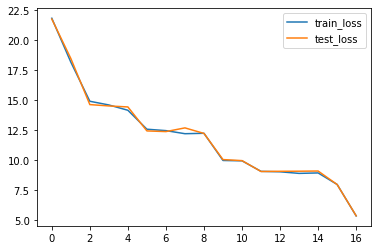

In [ ]:
eval_result = []
for i in range(1,18):
  events = [event_sequence[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_top_n_model(events, 1000)
  eval_result.append([train_loss*100, test_loss*100])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'test_loss'])
df_eval_result[['train_loss', 'test_loss']].plot()

Time_stamp 1 top_n 1000.0000 train_loss_g2 0.21393 train_rate_g2 1.00000 test_loss_g2 0.21470 test_rate_g2 1.00000
Time_stamp 2 top_n 1000.0000 train_loss_g2 0.12913 train_rate_g2 1.00000 test_loss_g2 0.13163 test_rate_g2 1.00000
Time_stamp 3 top_n 1000.0000 train_loss_g2 0.10313 train_rate_g2 1.00000 test_loss_g2 0.10450 test_rate_g2 1.00000
Time_stamp 4 top_n 1000.0000 train_loss_g2 0.09323 train_rate_g2 1.00000 test_loss_g2 0.09276 test_rate_g2 1.00000
Time_stamp 5 top_n 1000.0000 train_loss_g2 0.08186 train_rate_g2 1.00000 test_loss_g2 0.08182 test_rate_g2 1.00000


<AxesSubplot:>

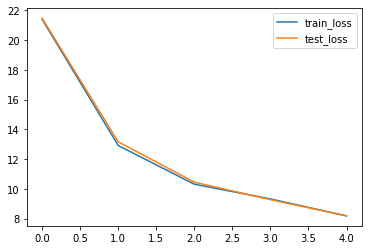

In [ ]:
eval_result = []
for i in range(1,6):
  events = [big_event[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_top_n_model(events, 1000)
  eval_result.append([train_loss*100, test_loss*100])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'test_loss'])
df_eval_result[['train_loss', 'test_loss']].plot()


n=5

In [ ]:
eval_result = []
for i in range(1,18):
  events = [event_sequence[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_top_n_model(events, 5)
  eval_result.append([train_loss*100, test_loss*100])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'test_loss'])
df_eval_result[['train_loss', 'test_loss']].plot()

In [ ]:
eval_result = []
for i in range(1,6):
  events = [big_event[j] for j in range(i)]
  train_loss, train_rate, test_loss, test_rate = eval_top_n_model(events, 5)
  eval_result.append([train_loss*100, test_loss*100])
df_eval_result = pd.DataFrame(eval_result, columns=['train_loss', 'test_loss'])
df_eval_result[['train_loss', 'test_loss']].plot()